# COGS 118A- Final Project

# Lung Classification

# Names


- William Wei
- Charmie Donasco
- Rizq Khateeb
- Michael Lai
- Siu Wu

# Abstract 
The goal of this project is to classify and differentiate between the chest X-ray images of COVID-19 positive cases, normal lungs, and Lung Opacity (Non-COVID lung infection). The data consists of images of X-rays and lung masks and will be measured by cutting the three classes down to 3600 images each (3600 Positive COVID-19, 3600 Normal Lungs, 3600 Lung Opacity (Non-COVID lung infection)) and compare each and see if there is more than a 33% match rate. We will be using CNN (convolutional neural network) to process the pixel data in the image to pick up on the differences in the images of the X-rays.

# Background

In recent years, image classification becomes more and more popular as they can extract characteristics from the images and then identify the correct the categories those images should belong to<a name="DluQweng"></a>[<sup>[1]</sup>](#DluQwengnote). This is beneficial and effective in the way that it saves a lot of time and effort when trying to categorize daramatic amount of images manually. There are lot of paper going over and reviewing the major techniques in the field of image classification and discussing over how to improve the performance. In related to our project, we have looked at papers which introduces the deep learning paradigm of Convolutional neual network(CNN). The paper discusses in detail about the development of CNN and its main features. The paper also introduces the potential limitations and applications of method of CNN<a name="Alzubaidi"></a>[<sup>[2]</sup>](#Alzubaidinote). We believe that the ability to identify the COVID-affected, normal and ohter lung infection patients based on the chest X-ray images would be meaningful and helpful since the pandemic still goes on.

# Problem Statement

The main problem this project will solve is diagnosis of lung conditions in patients. The x-ray images have key features that highlight the likely condition and indicate the diagnosis the patient should receive, but our project will use convolutional neural networks and train a model to ultimately classify whether the patient is healthy, afflicted with pneumonia, or has COVID automatically.

In [11]:
#Libraries
import os
import cv2
import numpy as np 
import tensorflow as tf
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D,BatchNormalization
from keras import backend as be
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from numpy.matlib import repmat
from sklearn.preprocessing import normalize


# Data

Link to the dataset: 
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

This data set contains 19820 imagnes of COVID-19 chest x-rays and lung masks each photo a png image with the diamentions of 299 by 299 pixels. The chest x-rays are images which showcase a scan of the entire chest area and the lung mask, which is provided by the dataset, is an additional black and white mask used to mask out everything in the chest x-rays besides the lungs. This is important as we want our model to primary focus on the lung portion of the X-ray and not to take in excess factors when classifying. Image of the X-ray and lung mask can be seen below.


<img src="images/example1.png">
<br> <img src="images/examplemask.png">

It is important moving forward with this dataset that we are able to isolate the lungs using the lung mask because as we can see, the data from the lungs is only a fraction of full image so seperating the image will not only vastly improve accuracy but also improve computation speed by reducing load. Some additional shifting of the dataset will we be doing is reducing the size of the dataset so there is 3000 images for each of the classes for the training set and 600 each for the testing data set. We do this so there is a base line 33%, if we do random selection, we can compare our model against to.
It takes quite a long time to apply masks images on the original images on the entire dataset in order to transform the data. Therefore, for the reason of computationality, we are only taking 300 examples for now as an example to demonstrate how we transforms the data。


In [2]:
path="COVID-19_Radiography_Dataset"

In [3]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'lung_condition'])

data['path'] = path + '/' + data['image_file']
data['lung_condition'] = data['lung_condition'].map({'Normal': 'Normal', 'COVID': 'Covid', 'Viral Pneumonia':'Pneumonia', 'Lung_Opacity':'Lung_Opacity'})

In [4]:
data

,image_file,lung_condition,path
0,Normal/images,Normal,COVID-19_Radiography_Dataset/Normal/images
1,Normal/masks,Normal,COVID-19_Radiography_Dataset/Normal/masks
2,COVID/images,Covid,COVID-19_Radiography_Dataset/COVID/images
3,COVID/masks,Covid,COVID-19_Radiography_Dataset/COVID/masks
4,Viral Pneumonia/images,Pneumonia,COVID-19_Radiography_Dataset/Viral Pneumonia/i...
5,Viral Pneumonia/masks,Pneumonia,COVID-19_Radiography_Dataset/Viral Pneumonia/m...
6,Lung_Opacity/images,Lung_Opacity,COVID-19_Radiography_Dataset/Lung_Opacity/images
7,Lung_Opacity/masks,Lung_Opacity,COVID-19_Radiography_Dataset/Lung_Opacity/masks


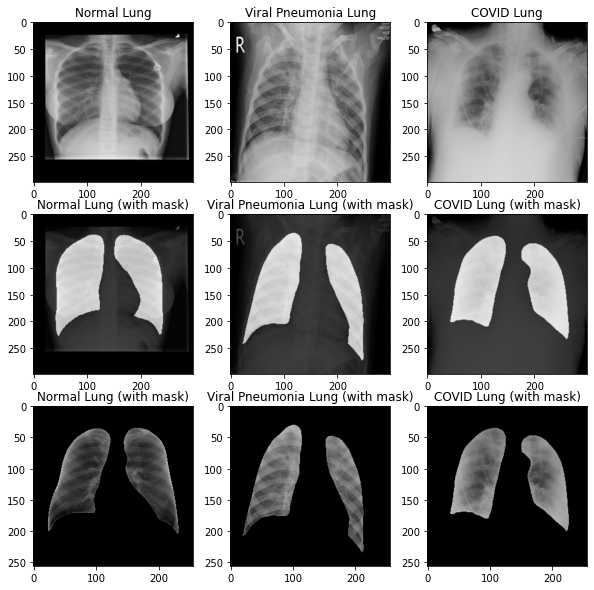

In [5]:
# create a 3 x 3 grid to display example images of each type
fig, axs = plt.subplots(3, 3, figsize=(10,10))

#No masks
axs[0][0].imshow(cv2.imread(f"{path}/Normal/images/Normal-1.png"))
axs[0][0].set_title('Normal Lung')
axs[0][1].set_title('Viral Pneumonia Lung')
axs[0][1].imshow(cv2.imread(f"{path}/Viral Pneumonia/images/Viral Pneumonia-1.png"))
axs[0][2].set_title('COVID Lung')
axs[0][2].imshow(cv2.imread(f"{path}/COVID/images/COVID-1.png"))

#Mask Overlay
axs[1][0].set_title('Normal Lung (with mask)')
axs[1][0].imshow(cv2.imread(f"{path}/Normal/images/Normal-1.png"))
axs[1][0].imshow(cv2.resize(cv2.imread(f"{path}/Normal/masks/Normal-1.png"), (299,299)), alpha=0.7)
axs[1][1].set_title('Viral Pneumonia Lung (with mask)')
axs[1][1].imshow(cv2.imread(f"{path}/Viral Pneumonia/images/Viral Pneumonia-1.png"))
axs[1][1].imshow(cv2.resize(cv2.imread(f"{path}/Viral Pneumonia/masks/Viral Pneumonia-1.png"), (299,299)), alpha=0.7)
axs[1][2].set_title('COVID Lung (with mask)')
axs[1][2].imshow(cv2.imread(f"{path}/COVID/images/COVID-1.png"))
axs[1][2].imshow(cv2.resize(cv2.imread(f"{path}/COVID/masks/COVID-1.png"), (299,299)), alpha=0.7)

#With Mask
axs[2][0].set_title('Normal Lung (with mask)')
axs[2][0].imshow(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/Normal/images/Normal-10.png"), (256,256)), cv2.imread(f"{path}/Normal/masks/Normal-10.png")))
axs[2][1].set_title('Viral Pneumonia Lung (with mask)')
axs[2][1].imshow(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/Viral Pneumonia/images/Viral Pneumonia-1.png"), (256,256)), cv2.imread(f"{path}/Viral Pneumonia/masks/Viral Pneumonia-1.png")))
axs[2][2].set_title('COVID Lung (with mask)')
axs[2][2].imshow(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/COVID/images/COVID-1.png"), (256,256)), cv2.imread(f"{path}/COVID/masks/COVID-1.png")))

plt.show()

Above is how the data images look like. The first row are the original lung images. The second row are the lung images with the mask images on them. The third row are the lung images that with mask images applied and neglecting all the unnecessary part.

In [6]:
#Apply the masks to the data
levels = ['Normal', 'COVID', 'Viral Pneumonia']

masked_images = {'Normal':[], 'COVID':[], 'Viral Pneumonia':[]}

for level in levels:
  for i in tqdm(range(1, 3001)):
    masked_images[level].append(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/"+level+"/images/"+level+"-"+str(i)+".png"), (256,256)), cv2.imread(f"{path}/"+level+"/masks/"+level+"-"+str(i)+".png")))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 429.00it/s]


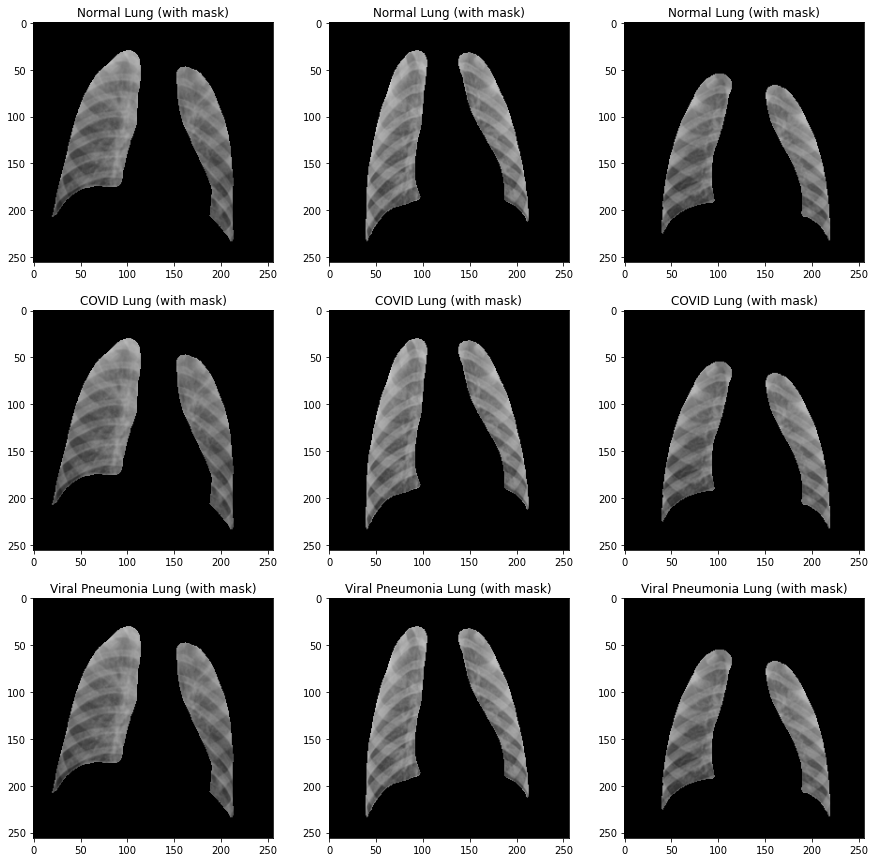

In [7]:
#Gallery
fig, axs = plt.subplots(3,3, figsize=(15,15))
for i in range(3):
  for j in range(3):
    axs[i][j].set_title(levels[i]+" Lung (with mask)")
    axs[i][j].imshow(masked_images[level][j])

# Proposed Solution

Our proposed solution would be implementing the algorithm of CNN to the dataset and then classify the images of lungs in the correct categories accordingly using the features extracted from the data. We will use the lung mask to crop out the images from the x-ray images. By cutting out the images we can reduce the amount of noise and allow the model to only focus on the areas which may contain elements of COVID-19. The model we are using is a Convolutional Neural Network, the CNN takes in an input image and uses weights and biases as well as various aspects in order to differentiate between each other. In the CNN the model there are multiple layers including the input, output, and hidden layer. The hidden layer consists of multiple convolutional layers, pooling layers, fully connected layers, and normalization layers. Some libraries we will use but are not limited to are the python libraries of keras and tensorflow. We want to use tensorflow in order to take advantage of its ability to utalize create complex neural networks and to run them effectively with its implementation of cuda cores. 

# Evaluation Metrics

By reducing our dataset into classes with equal quantities each we can assume a baseline 33% accuracy if we were to just use random assignment for our image dataset. This means that if our model is able to accurately distinguish the dataset above this 33% baseline we can assume that our model is somewhat successful. Other models that which use the same dataset have been found to have an accuracy over 95% and although we do not believe we will be able to reach such numbers, this does set us an upperbound for what we can expect to be achievable for the dataset. We will mark each image in the test dataset as correct if it able to correctly classify the image with its label and wrong if it fails to do so.

We will also look at the confusion matrix of the model to see how does our classification go. The confusion matrix can be used to evaluate the accuracy of the model. As to our project, the confusion matrix will have predicted classes of the lung images and the actual classes of the lung images. Therefore, the 2x2 matrix will have true positive, true negative, false positive and false negative as the rows and columns. We will calculate precision and recall to help us evaluating our model.

# Results
One of the very first problems that we as a group had to tackle was to find a model which would be best suited to work with our dataset. In order to narrow down the models we could have selected we took a deeper look at which models we could have used to best suit our dataset. Weighing our options we decided that the best models that we could have used for this project would be either a SVM or CNN model. A SVM model would not be as accurate as a CNN but in terms of implementation it would have been a lot easier. The SVM model will utilize the mean and standard deviation of the images as we have mentioned in the previous sections and would do a general divide between the different classes. While this would give a distinction between the normal and affected lungs, the difference between COVID and pneumonia would be close to impossible to distinguish based on our constraints. As such, it was in our best interest to continue work on a CNN model. A CNN model, while complicated, was the best model for us to use to differentiate between these three classes as the complexity of the CNN allowed for the model to differentiate between COVID and pneumonia which the SVM would not have been able to.

# Subsection 1 -- Preliminary results

While the training of models and analysis will take an extensive amount of time and work before any results may come into fruition. What we can instead do is preform some preliminarily testing to see how our model may, in fact, interpret our data. We can do so by simply looking at the mean and standard deviation of the image samples. 


In [16]:
samples = 300
levels = ['Normal', 'COVID', 'Viral Pneumonia']
mean_val = {'Normal':[], 'COVID':[], 'Viral Pneumonia':[]}
std_dev_val = {'Normal':[], 'COVID':[], 'Viral Pneumonia':[]}

for level in levels:
  for i in range(samples):
      mean_val[level].append(masked_images[level][i].mean())
      std_dev_val[level].append(np.std(masked_images[level][i]))

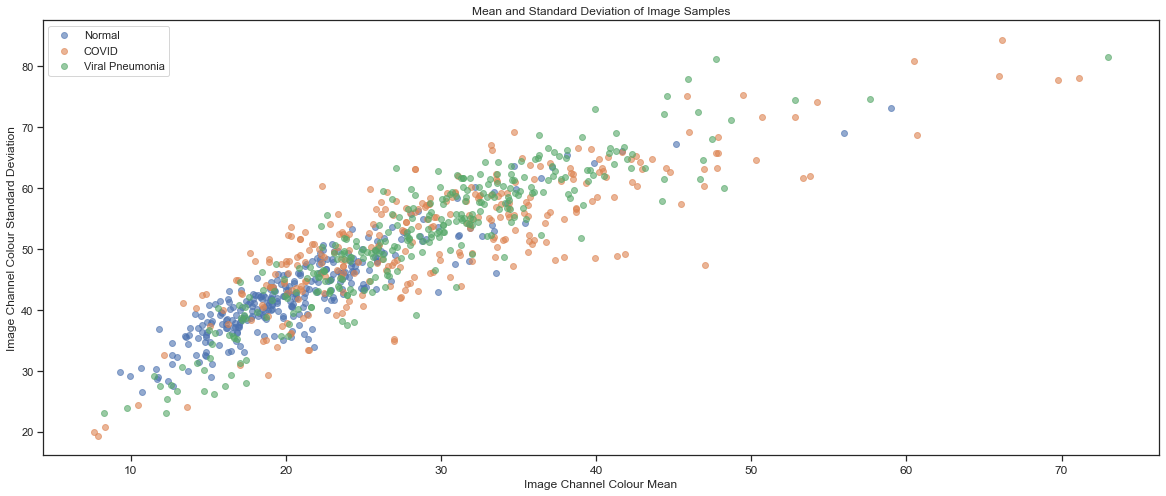

In [17]:
plt.figure(figsize=(20,8))
for level in levels:
  plt.scatter(mean_val[level], std_dev_val[level], label=level, alpha=0.6)
plt.title("Mean and Standard Deviation of Image Samples")
plt.legend(loc="upper left")
plt.xlabel("Image Channel Colour Mean")
plt.ylabel("Image Channel Colour Standard Deviation")
plt.xticks(rotation=0,fontsize = 12)
plt.show()

By looking at the mean and standard deviation of the image samples we can see some broad generalization of the data and see if, within the data there are any points of similarity. We first take a look at a scatter plot of all three levels plotted as different colors. Initial looks we can see that all the images follow a similar pattern with heavy concentrations on the middle of a right upwards line. We can assume that this central tendency is due impart from the masking of the dataset which removed a large part of noise from the images and leaving us with only the center part, aka the lungs.


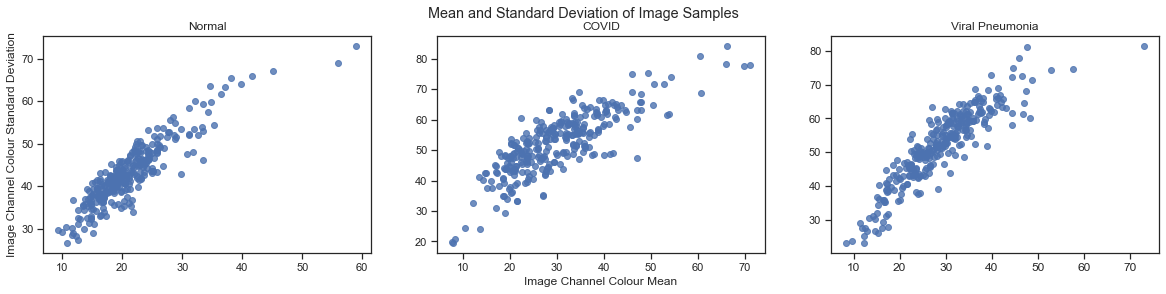

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20,4))
for i in range(3):
  axs[i].scatter(mean_val[levels[i]], std_dev_val[levels[i]], alpha=0.8)
  axs[i].set_title(levels[i])

axs[1].set_xlabel("Image Channel Colour Mean")
axs[0].set_ylabel("Image Channel Colour Standard Deviation")
plt.xticks(rotation=0,fontsize = 12)
plt.suptitle("Mean and Standard Deviation of Image Samples")
plt.show()

Next we will plot each of the levels in their own separate plots and see if there are any differentiating characteristics between the three levels. Although initially there does not seem to be any similarities between the three levels, upon closer inspection we can see that we could see that while normal lungs have centralized in the lower left portion of the graph, COVID and viral pneumonia both have their centralized points towards the middle of the graph. What we can discern for these differences is that COVID and pneumonia both cause damage to the lung tissue which in turn would result in white marks on the scans (the white marks on the scan highlight damaged tissue areas). Whereas in normal lungs, the absence of damaged tissues would make it such that there are much more dark areas meaning the image would have lower mean and standard deviation scores. While to differentiate between COVID and pneumonia will still take more analysis, this new knowledge will help us when creating our machine learning model.

# Subsection 2 -- CNN model

For the CNN model, we decide not use the pre-trained models like VGG16 or the LeNet-5 CNN models. What we did instead is to try to have our own versions of CNN models for this project. We build the model starting with the sequential frame since it is the easiest one to build as it is just stacks of layers where each layer has only one input tensor and output tensor. And then we just add layers to the model to build up the models. We also implement the callbacks functions when doing the model training as we are doing 800 epochs with images that have 256 * 256 pixels. Both learning_rate_reduction and early_stopping_monitor are monitoring on the value of validation loss. learning_rate_reduction will decrease the learning rate when validation loss stops improving for 8 epochs and early_stopping_monitor will stop the training process when validation loss stops improving for 80 epochs. Work from Kaggle also <a name="Weiaozhang"></a>[<sup>[3]</sup>](#Weiaozhang) inspires our model implement.

In [8]:
#Transform array back into images
image_path = "COVID-19_Radiography_Dataset/combine"
for level in levels:
  number = 0
  for j in range(3000):
    ima = Image.fromarray(masked_images[level][j])
    ima = ima.save(f"{image_path}/"+level+"/image"+str(number)+".png")
    number += 1

In [9]:
path="COVID-19_Radiography_Dataset/combine"
levels = ['Normal', 'COVID', 'Viral Pneumonia']
batch_size = 16

#Data split
gen_traindata = ImageDataGenerator(validation_split=0.2)

gen_testdata = ImageDataGenerator(validation_split=0.2)

training = gen_traindata.flow_from_directory(directory=path, 
                                             target_size=(256, 256),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True,
                                             classes=levels,
                                             batch_size=batch_size,
                                             color_mode="grayscale", 
                                              )

testing = gen_testdata.flow_from_directory(directory=path, 
                                           target_size=(256, 256),
                                           class_mode='categorical',
                                           subset='validation',
                                           shuffle=False,
                                           classes=levels,
                                           batch_size=batch_size,
                                           color_mode="grayscale", 
                                            )

Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


How We Made Our CNN Model

Our CNN model uses the Sequential model from Keras. The Keras library is very useful for deep-learning models, and like its name suggests, the Sequential API allows the model to be created layer by layer. After initializing the model, we then added multiple layer instances of convolution kernels using Conv2D, and added another layer instance of BatchNormalization to normalize the model. For some of the convolution kernels, we also used AveragePooling2D to downsample the input, and Dropout, which sets input units to 0 at a specified rate (0.25 in our case) during training to help prevent overfitting. At the end, we then compiled the model, and printed out a summary. 

In [10]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256, 256, 1)))
cnn_model.add(BatchNormalization())


cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(BatchNormalization())
cnn_model.add(AveragePooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(BatchNormalization())


cnn_model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(BatchNormalization())
cnn_model.add(AveragePooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(BatchNormalization())
cnn_model.add(AveragePooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(BatchNormalization())


cnn_model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(BatchNormalization())
cnn_model.add(AveragePooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Flatten())
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.25))


cnn_model.add(BatchNormalization())
cnn_model.add(Dense(3, activation='softmax'))


cnn_model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=[Recall(),
                  'accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 64)     0         
 ooling2D)                                                       
                                                        

In [11]:
epochs = 800
#callbacks for faster training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=8, verbose=0, factor=0.2, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=80, monitor='val_loss', mode = 'min', verbose=0)
callbacks = [learning_rate_reduction,early_stopping_monitor]
stats = cnn_model.fit(training,
                      validation_data=testing,
                      epochs=epochs,
                      callbacks=callbacks,
                      verbose = 0)

In [12]:
ypred = cnn_model.predict(testing)

113/113 [==============================] - 59s 524ms/step


# Subsection 3 -- Model interpretation

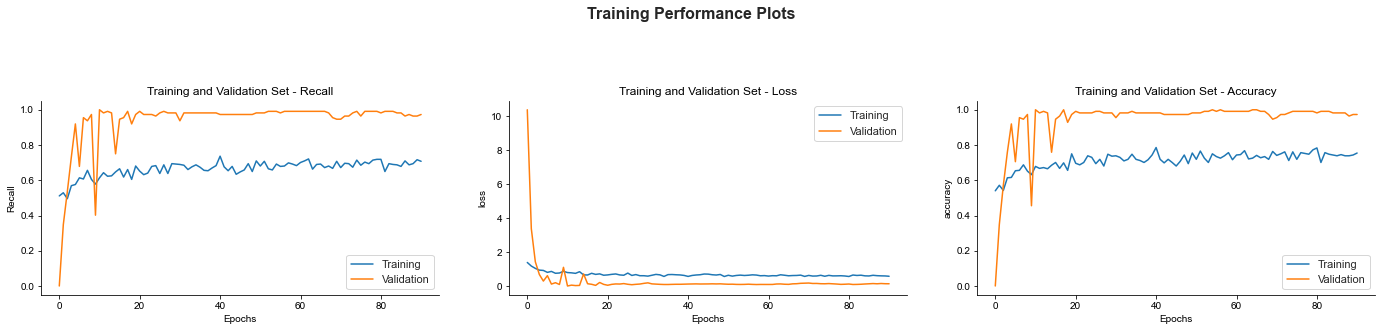

In [14]:
#Plots for recall/loss/acc
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.set(style="ticks", font_scale = 1)
df = pd.DataFrame.from_dict(stats.history)
ax = sns.lineplot(x = df.index, y = stats.history['recall'], ax=ax[0], label="Training");
ax = sns.lineplot(x = df.index, y = stats.history['val_recall'], ax=ax[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = df.index, y = stats.history['loss'], ax=ax[1], label="Training");
ax = sns.lineplot(x = df.index, y = stats.history['val_loss'], ax=ax[1], label="Validation");
ax.set_ylabel('loss')

ax = sns.lineplot(x = df.index, y = stats.history['accuracy'], ax=ax[2], label="Training");
ax = sns.lineplot(x = df.index, y = stats.history['val_accuracy'], ax=ax[2], label="Validation");
ax.set_ylabel('accuracy')

ax[0].set_title("Training and Validation Set - Recall")
ax[1].set_title("Training and Validation Set - Loss")
ax[2].set_title("Training and Validation Set - Accuracy")

for item in ax:
    item.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots', fontsize = 15, weight = 'bold');
plt.show()

The next fundamental part of making sure our model was running correctly was by looking at our training performance per epochs. For these graphs we used three metrics to measure our performance: recall, loss, and accuracy. Each of these metrics would measure different aspects of our model but overall we should expect the overall performance for all three metrics to improve with each epoch. As our graph shows, there is a general increase in the training data and a strong increase in the validation which shows that overall our model is improving with each epoch. Unfortunately, it looks like the training data is consistently performing worse than the validation data set when in practice it should have been the opposite. The reason behind this, the group believes, is due to the fact that there is a much larger dataset for the training data where there is the presence of difficult images while for the validation there is a smaller dataset and primarily “easy” images where the model results are then skewed to over perform. We can see citations where there were “hard” images on the validation and the performance would drop heavily despite the general upwards trend. (see the 10th epoch in recall graph). Ways we could have helped alleviate this problem would have been to increase the validation dataset and use cross validation. 


# Discussion

Result Interpretation

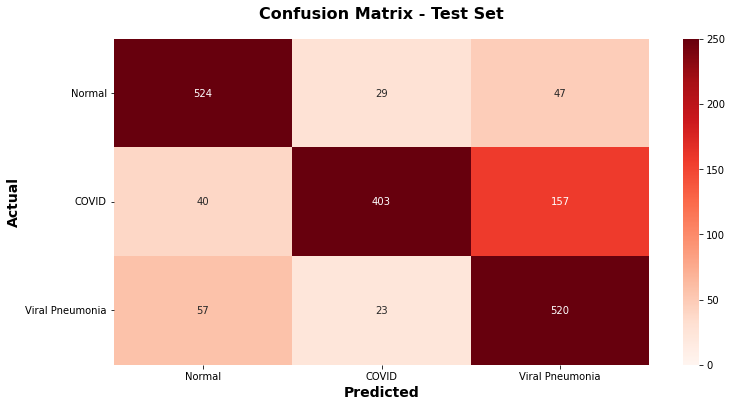

In [13]:
predictions = np.array(list(map(lambda x: np.argmax(x), ypred)))
ytrue=testing.classes
#Get DF for heatmap
CM = pd.DataFrame(confusion_matrix(ytrue, predictions), columns=levels, index =levels) 

plt.figure(figsize=(14, 7))
ax = sns.heatmap(CM, annot = True, fmt = 'g' ,vmin = 0, vmax = 250, cmap = 'Reds')
ax.set_xlabel('Predicted', fontsize = 14, weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14, weight = 'bold') 
ax.set_title('Confusion Matrix - Test Set', fontsize = 16, weight = 'bold')
be.clear_session()

In [15]:
#Stats of models
print(classification_report(ytrue, predictions, digits = 3))
print('normal = 0 , covid = 1, Viral Pneumonia = 2')

              precision    recall  f1-score   support

           0      0.844     0.873     0.858       600
           1      0.886     0.672     0.764       600
           2      0.718     0.867     0.785       600

    accuracy                          0.804      1800
   macro avg      0.816     0.804     0.803      1800
weighted avg      0.816     0.804     0.803      1800

normal = 0 , covid = 1, Viral Pneumonia = 2


We put the data into a confusion matrix to understand the difference between what the model would predict and what the actual results were. As shown on the confusion matrix, the bright red square on the right middle is where the model predicted pneumonia but it was actually COVID. This showed our model's tendency to confuse the analysis of patient’s lungs who had COVID for pneumonia. This was interesting for our group to tackle as we wanted to improve the model so that this sort of error was less likely to happen in future runs. There is a general increase in the training data in the graph as well as a strong increase in the validation which showed that the model was overall improving with each epoch.  However, the training data seemed to be consistently performing worse than the validation data set despite our expectations that in practice, the opposite should’ve occurred.

 Limitations

We found that there wasn’t enough data available to actually produce meaningful results. Perhaps if we looked for much larger datasets then our models would produce better results to be interpreted. Though this also meant that our model could’ve become inefficient in tackling the analysis of such large datasets. The CNN model proved to be quite sufficient for our purposes but it definitely seemed limited after seeing that the size of the dataset we currently had wasn’t quite producing the results that we were looking for. The training data consisted of a much larger size in comparison to the test data which was smaller and consisted of primarily “easy” images leading to the model to over perform and so the results were skewed. Increasing the validation set and perhaps the use of cross validation would’ve definitely alleviated the issue with the size of the datasets and improved how the model was learning from “easy” and “hard” images on the validation.


# Ethics & Privacy

This project is- at its base- an image classification project. While this specific project would help the efficiency in the medical field in terms of predictive diagnosis in respiratory illnesses and further research, the idea of image recognition in broader terms can be a topic that faces a lot of scrutiny. One of the main issues with image recognition are deepfakes. Deepfakes are essentially videos or images that takes a preexisting image/video and replaces the person in it with someone else's image/video. This can lead to a lot of misleading content as it can pass content that never existed as something genuine. For example, inserting a random person's face onto an incriminating video and passing it off as evidence for a crime and such. 

Anther issue that our project may come across specifically, is the privacy of the patients whose X-ray images come from. A patient's privacy is still extended in this case therefore, any electronic medical information must be secure. Theoretically, if this project is to be remade with original an dataset, the first step is to receive the patient's explicit consent in sharing the images and minor detail that is would be considered important to the research. Next is to remove names or anything that will be able to determine a patient's identity from the dataset.

# Conclusion

The purpose of our project was to ultimately be able to classify lung X-ray images and differentiate between normal, COVID-19, and viral pneumonia scans. To go about this, we wrangled and cleaned our dataset to make the images more readable and highlight the differences. Since the X-ray images are of the whole chest cavity, we wanted to cancel out the noise surrounding the center of the image where most of the desirable information lies. We performed masking on the images to isolate the parts of the scans that we are only interested in. After implementing the masks on the images, we analyzed the mean and standard deviation of the image’s channel color and found, through a scatter plot, that the three classes (normal, COVID-19, and viral pneumonia) all follow a similar pattern of a positive linear pattern. It is discovered that within this linear pattern, there is a tendency to cluster in the middle for all classes. The COVID-19 and pneumonia scans tend to group higher, indicating that the damaged tissues result in more white marks on the scans. The normal lungs have lower standard deviation and mean, indicating presence of less damage. After the preliminary analysis of the masks, we decided to do the image classification with a CNN model, or a Convolutional Neural Network. Based on the confusion matrix, our model is successful in identifying the different classes of the images. It can be seen, however, that if COVID-19 was to be misclassified, it would be identified as a viral pneumonia scan. Overall, our project was successful in classifying the different classes.

# Team Expectations 

* Each group member shows up to meetings and stay updated on project progress
* Getting the assigned work done before next meeting so that project can be progressed
* Ask for help from each other or TAs/professor if assistance is needed
* Split up the work to make things easier to handle and such that everyone contributes to the project
* Respect each other
* Respond to the group messages

# Project Timeline Proposal

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/28  |  9 PM |  Brainstorm topics/questions (all)  | Discuss and decide on final project topic; discuss hypothesis; begin background research; PEER REVIEWS (DUE 4/29) | 
| 5/7  |  8 PM |  Do background research on topic; Dataset search and wrangling | Check ups: EDA, data processed, algorithms, etc. | 
| 5/12  | 9 PM  | Prep for checkpoint (as discussed in previous meeting)| More discuss over data wrangling and EDA |
| 5/18  | 8 PM  | EDA and data wrangling | Figure out the preliminary results section of the checkpoint |
| 5/19  | 8 PM  | Continue previous meeting | Continue and finish up the checkpoint  |
| 5/25  | 8 PM  | Model selection| Models results and comparison   |
| 5/28  | 8 PM  | Analysis | Analysis; Discuss/edit project code; Complete project |
| 6/04  | 8 PM  | Complete analysis; Draft results/conclusion/discussion (Carlos)| Discuss/edit full project |
| 6/10  | Before noon  | NA | Turn in Final Project  |

# Footnotes
<a name="DluQwengnote"></a>1.[^](#DluQweng): D.Lu, Q.Weng Review Article a Survey of Image- Tandfonline.com. https://www.tandfonline.com/doi/pdf/10.1080/01431160600746456. <br> 
<a name="Alzubaidinote"></a>2.[^](#Alzubaidi): Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. J Big Data 8, 53 (2021). https://doi.org/10.1186/s40537-021-00444-8<br>
<a name="Weiaozhang"></a>3.[^](#Weiaozhang): Zhang. W. Kaggle codes which inspires our project.
https://www.kaggle.com/code/weiaozhang/deep-learning-project-final-output